# Estradiol + Progesterone Hormone Data
Update: May 1, 2023

- [X] Linear regression assumes independence. Since our hormone data is not independent, we need to use mixed effect model.
- [X] Export csv for mixed effect model in R
- [X] [Mixed Effect Model](https://heather-grab.github.io/Entom-4940/mixed.html#introduction_to_mixed_models)
    - We have crossed interaction term, which can be accounted for with X*Y
    - Check estimated variance of random variables. If ~0, can just use linear model instead
    - Check correlation between fixed effects: if highly correlated, have multicollinearity. Would need to construct
     separate models and see which covariates to keep.
    - Drop terms with highest order, highest p-value first to compare models.
- Note that we do not need to drop the 10 mis-timed cycles in the LME model because in our LME we do not use phase
at all, instead we use the hormone measurements directly.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math

import OAM_functions as ov_func
import Towlson_group_code.data_io as myFunc
import Towlson_group_code.brain_network as bnet

FIG_PATH = '../../Ovarian_hormone/Figures/hormones/'
PICKLE_PATH = '../../Ovarian_hormone/pickles/'
phase_map = {0: 'EF', 1: 'LF', 2: 'ML'}

Load data

In [23]:
all_cycles = myFunc.load_from_pickle('../../Ovarian_hormone/pickles/', 'all_cycles.pkl')
ef_input_params = myFunc.load_from_pickle("../../Ovarian_hormone/pickles/individual_connectomes/",
                                          "ef_input_params.pkl")
ef_name_to_idx = {x[0]: x[1] for x in ef_input_params.values()}

def get_cycle_adj_matrices(ci):
    ef_scan, lf_scan, ml_scan = all_cycles[ci]
    idx = ef_name_to_idx[ef_scan+'.pkl']
    a1 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/individual_connectomes/{idx}/', ef_scan+'.pkl')
    a2 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/individual_connectomes/{idx}/', lf_scan+'.pkl')
    a3 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/individual_connectomes/{idx}/', ml_scan+'.pkl')
    return [a1, a2, a3]

def get_cycle_partitions(ci):
    ef_scan, lf_scan, ml_scan = all_cycles[ci]
    a1 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/best_subject_auditory/', ef_scan+'_auditory.pkl')
    a2 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/hypothesis_tested/',
                                 f'cycle_{ci}_LF_partition_auditory_EF.pkl')
    a3 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/hypothesis_tested/',
                                 f'cycle_{ci}_ML_partition_auditory_LF.pkl')
    return [a1, a2, a3]

def get_ef_partition(ci):
    ef_scan, _, _ = all_cycles[ci]
    return myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/best_subject_auditory/', ef_scan+'_auditory.pkl')

hormone_data = myFunc.load_from_pickle("../../Ovarian_hormone/pickles/", "hormones_df.pkl")
hormone_data["Estradiol"] = hormone_data["Estradiol"]*0.001
colors = [ov_func.ICN_COLORS_HEX[icn] for icn in range(9)]
print("Hormone data:")
print(hormone_data.head(5))

Hormone data:
   Cycle Phase  Progesterone  Estradiol
0      0    EF          0.12     0.0248
1      0    LF           NaN        NaN
2      0    ML          5.97     0.1210
3      1    EF          0.14     0.0425
4      1    LF           NaN        NaN


Reformat hormone data

In [24]:
cycle_subj_id = {c: 'OAM'+cycle_phases[0][3:6] for c, cycle_phases in enumerate(all_cycles)}
data = {'cycle': [], 'subject': [], 'phase': [], 'est': [], 'pro': []}
for r in hormone_data.iterrows():
    hrow = r[1]
    c = hrow['Cycle']
    if math.isnan(hrow['Estradiol']) or math.isnan(hrow['Progesterone']) :
        continue
    if c in ov_func.REMOVE:
        continue
    data['cycle'].append(c)
    data['subject'].append(cycle_subj_id[c])
    data['phase'].append(hrow['Phase'])
    data['est'].append(hrow['Estradiol'])
    data['pro'].append(hrow['Progesterone'])
hormone_df = pd.DataFrame(data = data)

print(len(hormone_df))
hormone_df.head(5)

34


,cycle,subject,phase,est,pro
0,0,OAM035,EF,0.0248,0.120
1,0,OAM035,ML,0.1210,5.970
2,2,OAM017,EF,0.0339,0.068
3,2,OAM017,LF,0.0549,0.042
4,2,OAM017,ML,0.0916,7.850


Violin plot of hormone distributions

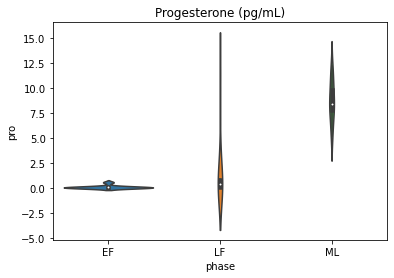

phase       pro          
             mean       std
0    EF  0.133650  0.167447
1    LF  1.647545  3.400506
2    ML  8.773077  2.063074

In [31]:
sns_plot = sns.violinplot(data=hormone_df, x="phase", y="pro", order=[ "EF", "LF", "ML"])
fig = sns_plot.get_figure()
sns_plot.set(title="Progesterone (pg/mL)")
# fig.savefig("../Ovarian_hormone/Figures/Progesterone distribution.png")
plt.show()

hormone_df.groupby('phase', as_index=False).agg({'pro':['mean','std']})

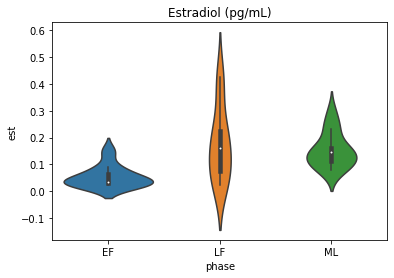

phase       est          
             mean       std
0    EF  0.054470  0.039466
1    LF  0.175527  0.135708
2    ML  0.154246  0.064472

In [32]:
sns_plot = sns.violinplot(data=hormone_df, x="phase", y="est", order=[ "EF", "LF", "ML"])
fig = sns_plot.get_figure()
sns_plot.set(title="Estradiol (pg/mL)")
# fig.savefig("../Ovarian_hormone/Figures/Estradiol distribution.png")
plt.show()

hormone_df.groupby('phase', as_index=False).agg({'est':['mean','std']})

## Connectivity Strength
Export connectivity strength data between two sets of nodes (1 set is the nodes belonging to a ROI, and 2nd set are
the nodes belonging to a functional network). Data is then used to create LME model in R.

In [20]:
joes_list =  {"r": [],
              "l": [1031]}
region_name = "Thalamus Left"

ddfrois = {"l": [x-1 for x in joes_list["l"]], "r": [x-1 for x in joes_list["r"]]}
m2 = ddfrois["l"] + ddfrois["r"]

data_dict = {'module': [], 'cycle': [], 'phase': [], 'metric': []}
moi = 6
fname = f"{region_name} - {ov_func.AVG_EF_FN_ACRYNOMS[moi]} connectivity"

for c in tqdm(range(30)):
    if c in ov_func.REMOVE:
        continue
    cycle_W = get_cycle_adj_matrices(c)
    ef_P = get_cycle_partitions(c)[0]
    icn_nodes = np.where(np.array(ef_P) == moi)[0]
    m = list(set(icn_nodes) - set(m2))

    for phase_i, W in enumerate(cycle_W):
        pos, neg = bnet.nodal_connectivity_strength(W, m2, m)

        data_dict['module'].append(fname)
        data_dict['cycle'].append(c)
        data_dict['phase'].append(phase_map[phase_i])
        data_dict['metric'].append(pos)

connectivity_df = pd.DataFrame(data_dict)
data_model_df = connectivity_df.merge(hormone_df, how='left', on=['cycle', 'phase'])
data_model_df = data_model_df.dropna()
print(len(data_model_df))

100%|██████████| 30/30 [00:00<00:00, 77.04it/s]

34


In [ ]:
data_model_df.to_csv('../Ovarian_hormone/Dump/connectivity_strength_hormone_data.csv')

# Interaction Strength
Export interaction strength data between two sets of nodes (1 set is the nodes belonging to a ROI, and 2nd set are
the nodes belonging to a functional network).
Data is then used to create LME model in R.

In [ ]:
P = myFunc.load_from_pickle(PICKLE_PATH, 'module_allegiance.pkl')

In [ ]:
joes_list =  {"r": [832,835],
              "l": [398,310]}
region_name = "Temporal pole"

ddfrois = {"l": [x-1 for x in joes_list["l"]], "r": [x-1 for x in joes_list["r"]]}
data_dict = {'module': [], 'cycle': [], 'phase': [], 'metric': []}

m2 =  ddfrois['l']+ ddfrois['r']
moi = 5
fname = f"{region_name} - {ov_func.AVG_EF_FN_ACRYNOMS[moi]} interaction"

for c in tqdm(range(30)):
    if c in ov_func.REMOVE:
        continue
    ef_P = get_cycle_partitions(c)[0]
    icn_nodes = np.where(np.array(ef_P) == moi)[0]
    m = set(icn_nodes) - set(m2)
    for phase_i in range(3):
        data_dict['module'].append(fname)
        data_dict['cycle'].append(c)
        data_dict['phase'].append(phase_map[phase_i])
        data_dict['metric'].append(bnet.interaction_strength_of_nodes(P[phase_map[phase_i]], m2, m))
connectivity_df = pd.DataFrame(data_dict)
data_model_df = connectivity_df.merge(hormone_df, how='left', on=['cycle', 'phase'])
data_model_df = data_model_df.dropna()
print(len(data_model_df))

In [ ]:
data_model_df.to_csv('../Ovarian_hormone/Dump/interaction_strength_hormone_data.csv')
